**Décimo segundo Trabalho da disciplina RNA e Deep Learning**

Discente: Valéria Cristina A. R. de Figueredo

# Rede neural com camadas escondidas - Classificação do Iris dataset

O objetivo desse experimento é ilustrar o uso de rede neural que tenha mais de uma camada. Isso é conseguido com a inserção de uma ativação não linear entre as camadas.

Datasets utilizados:
    - Iris - 3 classes
    - Sintéticos:
        - meia luas
        - círculos circunscritos
        - blobs

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/Net2RegressaoSoftmaxArgmaxRede.png)

## Importando as bibliotecas

In [69]:
%matplotlib inline
from sklearn import datasets
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn as nn

## Leitura, normalização e visualização dos dados

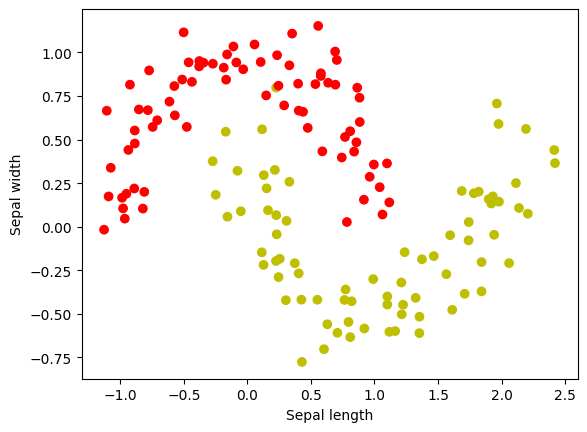

In [70]:
n_samples = 150
options = ['iris', 'moon', 'circles', 'blobs']
option = options[1]
if option == 'iris':
    iris = datasets.load_iris()
    X = iris.data[:,:2]  # comprimento das sépalas e pétalas, indices 0 e 2
    Xc = X - X.min(axis=0)
    Xc /= Xc.max(axis=0)
    Y = iris.target
elif option == 'moon':
    Xc,Y = datasets.make_moons(n_samples=n_samples, noise=.15)
elif option == 'circles':
    Xc,Y = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.1)
elif option == 'blobs':
    Xc,Y = datasets.make_blobs(n_samples=n_samples,centers=3,cluster_std=1.2)

colors = np.array(['r','y','b'])
plt.scatter(Xc[:, 0], Xc[:, 1], c=colors[Y])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

### Prepara os dados para o PyTorch

In [71]:
X_tensor = torch.FloatTensor(Xc)
Y_tensor = torch.LongTensor(Y)

## Construindo o modelo da rede

In [72]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 5),
            nn.ReLU(),
            nn.Linear(5, 5),
            nn.ReLU(),
            nn.Linear(5,3),
        )

    def forward(self, x):
        x = self.dense(x)

        return x

model = Modelo()
print(model)

Modelo(
  (dense): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=5, bias=True)
    (3): ReLU()
    (4): Linear(in_features=5, out_features=3, bias=True)
  )
)


## _predict_ utilizada para predição de classes e na visualização

In [73]:
def predict(model, inputs):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)

    return predicts.data.numpy()

## Classe para visualização dinâmica

In [74]:
class BoundaryPlotter():
    def __init__(self, model, X, Y, n_epoch, filepath=None, h = .01):
        self.model = model
        self.X = X
        self.Y = Y
        self.n_epoch = n_epoch
        self.filepath = filepath
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        self.xx, self.yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        self.loss_hist = []
        self.val_loss_hist = []
        self.X_grid = np.c_[self.xx.ravel(), self.yy.ravel()]

        #Gráficos a serem mostrados pelo callback
        self.fig = plt.figure(figsize=(8, 4), dpi=100)
        self.ax1 = self.fig.add_subplot(1, 2, 1)
        self.ax1.set_xlim(0, nb_epoch)
        self.ax1.set_xlabel('Epoca')#,fontsize=28)
        self.ax1.set_ylabel('Perda')#,fontsize=28)
        self.ax1.plot([],[],'b',linewidth = 2.0,label = "Treino")
        self.ax1.grid(True)

        self.ax2 = self.fig.add_subplot(1, 2, 2)
        self.ax2.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax2.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax2.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax2.set_ylabel('Largura da Sepala')#,fontsize=28)

    def on_train_begin(self, logs={}):
        display.display(self.fig)
        display.clear_output(wait=True)

    def on_epoch_end(self, epoch, logs={}):
        if 'loss' in logs.keys():
            self.loss_hist.append(logs['loss'])

            if epoch%250==0:
                self.ax1.plot(np.arange(epoch+1), self.loss_hist, 'b', linewidth = 2.0)

                Z = predict(self.model, torch.from_numpy(self.X_grid).type(torch.FloatTensor))
#                 Z = torch.max(self.model(Variable(torch.FloatTensor(self.X_grid))).data, dim=1)[1].numpy()
                Z = Z.reshape(self.xx.shape)

                self.ax2.pcolormesh(self.xx, self.yy, Z, cmap=plt.cm.Paired)
                colors = np.array(['r','y','b'])
                self.ax2.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                display.display(self.fig)
                display.clear_output(wait=True)

## Treinamento

In [75]:
lr = 0.15

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

### Laço principal de treinamento

Final loss: tensor(0.0226)


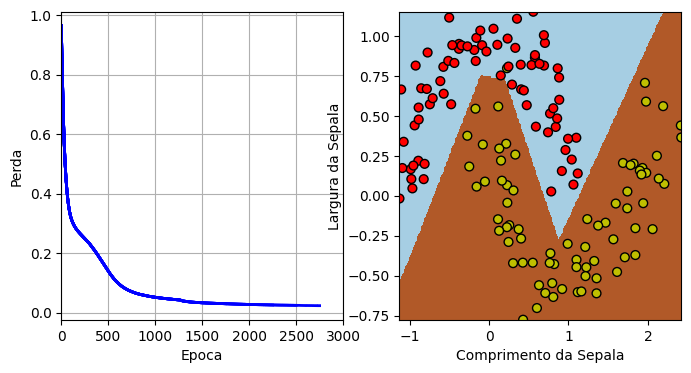

In [76]:
batch_size = 150
nb_epoch = 3000

#Definindo o plotter
boundary_plot = BoundaryPlotter(model, Xc, Y, nb_epoch)

boundary_plot.on_train_begin()
losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    loss = criterion(output, Variable(Y_tensor))

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data)

    boundary_plot.on_epoch_end(i, {'loss': loss.data})

print('Final loss:', loss.data)

## Avaliação

### Imprimindo pesos finais

In [77]:
for name, w in model.state_dict().items():
    print('{:16}{}'.format(name, w.size()))
    print(w)

dense.0.weight  torch.Size([5, 2])
tensor([[-2.3123,  0.3644],
        [-1.0679,  0.9451],
        [ 1.3854, -0.9270],
        [-2.4006,  0.1567],
        [ 1.0550,  0.1567]])
dense.0.bias    torch.Size([5])
tensor([-0.5434,  1.6397,  1.1504,  2.1430,  1.0713])
dense.2.weight  torch.Size([5, 5])
tensor([[ 1.2816,  0.7546, -1.3281,  0.9319, -1.3390],
        [-1.5309, -1.6600,  1.0820,  2.5957, -0.3527],
        [-1.1411, -0.9542,  0.7184,  1.5892, -0.3015],
        [-0.0868, -0.4225,  0.2188,  0.3515, -0.3833],
        [ 0.3161, -0.2643,  0.2235,  0.3232, -0.1453]])
dense.2.bias    torch.Size([5])
tensor([-0.3609, -0.6426, -0.3957, -0.3817, -0.3827])
dense.4.weight  torch.Size([3, 5])
tensor([[ 1.9570, -2.0878, -1.5049,  0.2833, -0.2147],
        [-1.5876,  2.8625,  1.5882,  0.1924, -0.4426],
        [ 0.0999, -0.9442, -0.7874,  0.0590,  0.2869]])
dense.4.bias    torch.Size([3])
tensor([ 3.8548, -1.4009, -2.3758])


### Avaliação do classificador

In [78]:
Y_hat = predict(model, X_tensor)
accuracy = (Y_hat == Y).mean()
print()
print('Training Accuracy: ', accuracy)


Training Accuracy:  0.9933333333333333


### Matriz de confusão

In [79]:
import pandas as pd
pd.crosstab(Y_hat, Y)

col_0,0,1
row_0,,
0,75,1
1,0,74


## Atividades

### Experimentos:

1. Faça alterações na rede, alterando o número de neurônios, de camadas. Escreva suas conclusões.
2. No lugar da ReLU, coloque Sigmoid e observe a diferença. O que aconteceu? Descreva.
3. O que ocorre quando não se utiliza ativação não linear entre camadas?

Final loss: tensor(0.0140)
dense.0.weight  torch.Size([10, 2])
tensor([[ 1.1389, -0.0810],
        [ 0.2411, -0.6606],
        [-0.5888, -0.8140],
        [ 0.9651, -0.4793],
        [ 0.2160,  0.2352],
        [-1.9025,  0.6498],
        [-0.2950,  0.3689],
        [-0.1387, -0.0482],
        [-0.3339,  0.4605],
        [ 1.1345,  0.5039]])
dense.0.bias    torch.Size([10])
tensor([ 0.2379,  0.1437,  0.6894, -0.7865, -0.6448, -0.1155,  0.5389,  0.5461,
         0.4904, -0.0572])
dense.2.weight  torch.Size([15, 10])
tensor([[-0.0382,  0.0735, -0.2333, -0.4406, -0.2280,  0.2198,  0.3886, -0.0185,
          0.1776,  0.1297],
        [-0.0234,  0.1868,  0.5622,  0.0465,  0.2034, -0.5526,  0.0746,  0.2390,
          0.0332, -0.0022],
        [-0.0011, -0.0302, -0.1011,  0.2751, -0.0216, -0.1976, -0.2474,  0.2319,
          0.2607, -0.2635],
        [-0.5511, -0.2287,  0.3088, -0.1192,  0.2482, -0.8882,  0.0918,  0.2743,
          0.2407, -0.4072],
        [-0.2359,  0.0038,  0.1292, -0.1459

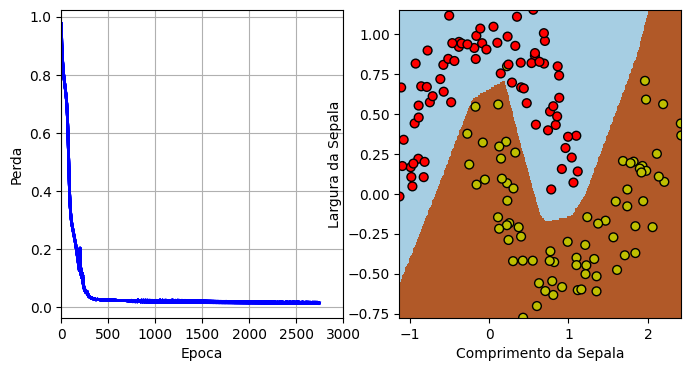

In [80]:
#Primeira Questão
class Modeloalterado(nn.Module):
    def __init__(self):
        super(Modeloalterado, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 10),  # Aumento para 10 neurônios na primeira camada
            nn.ReLU(),
            nn.Linear(10, 15),  # Aumento para 15 neurônios na segunda camada
            nn.ReLU(),
            nn.Linear(15, 8),  # Redução para 8 neurônios na terceira camada
            nn.ReLU(),
            nn.Linear(8, 5),  # Redução para 5 neurônios
            nn.ReLU(),
            nn.Linear(5, 3),  # Camada de saída com 3 neurônios
        )

    def forward(self, x):
        x = self.dense(x)
        return x

model = Modeloalterado()
print(model)

def predict(model, inputs):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)

    return predicts.data.numpy()

    class BoundaryPlotter():
      def __init__(self, model, X, Y, n_epoch, filepath=None, h = .01):
        self.model = model
        self.X = X
        self.Y = Y
        self.n_epoch = n_epoch
        self.filepath = filepath
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        self.xx, self.yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        self.loss_hist = []
        self.val_loss_hist = []
        self.X_grid = np.c_[self.xx.ravel(), self.yy.ravel()]

        #Gráficos a serem mostrados pelo callback
        self.fig = plt.figure(figsize=(8, 4), dpi=100)
        self.ax1 = self.fig.add_subplot(1, 2, 1)
        self.ax1.set_xlim(0, nb_epoch)
        self.ax1.set_xlabel('Epoca')#,fontsize=28)
        self.ax1.set_ylabel('Perda')#,fontsize=28)
        self.ax1.plot([],[],'b',linewidth = 2.0,label = "Treino")
        self.ax1.grid(True)

        self.ax2 = self.fig.add_subplot(1, 2, 2)
        self.ax2.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax2.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax2.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax2.set_ylabel('Largura da Sepala')#,fontsize=28)

    def on_train_begin(self, logs={}):
        display.display(self.fig)
        display.clear_output(wait=True)

    def on_epoch_end(self, epoch, logs={}):
        if 'loss' in logs.keys():
            self.loss_hist.append(logs['loss'])

            if epoch%250==0:
                self.ax1.plot(np.arange(epoch+1), self.loss_hist, 'b', linewidth = 2.0)

                Z = predict(self.model, torch.from_numpy(self.X_grid).type(torch.FloatTensor))
#                 Z = torch.max(self.model(Variable(torch.FloatTensor(self.X_grid))).data, dim=1)[1].numpy()
                Z = Z.reshape(self.xx.shape)

                self.ax2.pcolormesh(self.xx, self.yy, Z, cmap=plt.cm.Paired)
                colors = np.array(['r','y','b'])
                self.ax2.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                display.display(self.fig)
                display.clear_output(wait=True)

lr = 0.15

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

batch_size = 150
nb_epoch = 3000

#Definindo o plotter
boundary_plot = BoundaryPlotter(model, Xc, Y, nb_epoch)

boundary_plot.on_train_begin()
losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    loss = criterion(output, Variable(Y_tensor))

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data)

    boundary_plot.on_epoch_end(i, {'loss': loss.data})

print('Final loss:', loss.data)

for name, w in model.state_dict().items():
    print('{:16}{}'.format(name, w.size()))
    print(w)

Y_hat = predict(model, X_tensor)
accuracy = (Y_hat == Y).mean()
print()
print('Training Accuracy: ', accuracy)



**CONCLUSÕES:**

Primeiro, será realizada uma análise teórica sobre o tema.

Modificar o número de neurônios e camadas é importante para balancear a capacidade do modelo e o risco de overfitting. Para isso também é importante considerar o tempo e os recursos computacionais.

**Número de neurônios:**

Aumentar o número de neurônios pode dar ao modelo maior capacidade de aprender representações mais complexas dos dados mas também aumentar o risco de overfitting, especialmente em datasets pequenos. Isso pode diminuir com regularização ou maior quantidade de dados.

Já a Redução do número de neurônios diminui a capacidade de aprendizado do modelo, mas pode evitar overfitting e diminuir o tempo de treinamento, além de ser útil quando se trabalha com dados mais simples.

**Número de camadas:**

Adicionar mais camadas pode melhorar a capacidade do modelo de aprender padrões mais complexos (não-linearidades) dos dados, mas também aumenta a complexidade do modelo. Isso pode levar a um maior custo computacional e maior risco de overfitting. Ademais, pode ser útil se os dados forem muito complexos ou se a tarefa exigir aprendizado em diferentes escalas de abstração.

Mais camadas aumenta o tempo de treinamento e recursos computacionais. Além disso, pode ser mais difícil de otimizar devido ao aumento da profundidade e da complexidade. O problema é quando a rede é muito complexa em relação à quantidade de dados disponíveis, o que pode resultar em overfitting, onde o modelo aprende bem com os dados de treinamento, mas não generaliza bem para novos dados. Algumas técnicas para buscar resolver o problema são dropout, regularização L2 e aumento de dados.

No experimento observado nesse momento, verificou-se que antes da modificação dos neurônios,a perda era 0.0226 e acurácia 0.9933. Depois da modificação dos neurônios, a perda passou para 0.0140 e a acurácia não se modificou, continuou 0.9933. Desse modo, é possível verificar que a rede não tem muita complexidade para aprender com muitos neurônios. Isto é, como um problema simples, não precisa aumentar muito os neurônios, o que pode resultar em overfitting.


Final loss: tensor(0.2745)
dense.0.weight  torch.Size([5, 2])
tensor([[ 2.7987e-01, -2.6149e+00],
        [-3.9191e-01, -2.2588e-03],
        [ 4.5488e-01, -8.8024e-01],
        [-4.8773e-01,  1.5479e+00],
        [-4.9870e-01,  8.5704e-01]])
dense.0.bias    torch.Size([5])
tensor([-0.4343,  0.0955,  0.4227, -0.1345, -0.5542])
dense.2.weight  torch.Size([5, 5])
tensor([[-2.4472, -0.1148, -0.2754,  1.1964,  0.8564],
        [ 1.8617, -0.5078,  0.7640, -1.3005, -0.3374],
        [ 1.7830, -0.0620,  0.6618, -0.5431, -0.7562],
        [-1.4228,  0.2212, -0.5446,  1.0265,  0.5712],
        [-0.3342, -0.2176, -0.2558, -0.0323, -0.0219]])
dense.2.bias    torch.Size([5])
tensor([ 3.2869e-01,  2.8151e-01, -2.6611e-01,  2.7493e-04,  2.4503e-01])
dense.4.weight  torch.Size([3, 5])
tensor([[ 2.7617, -1.5907, -1.1298,  1.7596,  0.4735],
        [-1.8493,  2.4553,  2.2230, -1.0503,  0.1541],
        [-0.4829, -1.3564, -0.4728, -1.0800, -0.7556]])
dense.4.bias    torch.Size([3])
tensor([ 0.8034,  1.1

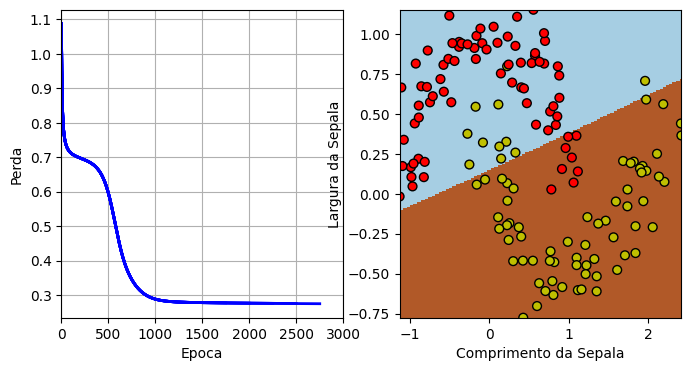

In [81]:
#Segunda Questão
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 5),
            nn.Sigmoid (),
            nn.Linear(5, 5),
            nn.Sigmoid (),
            nn.Linear(5,3),
        )

    def forward(self, x):
        x = self.dense(x)

        return x

model = Modelo()
print(model)

def predict(model, inputs):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)

    return predicts.data.numpy()

    class BoundaryPlotter():
      def __init__(self, model, X, Y, n_epoch, filepath=None, h = .01):
        self.model = model
        self.X = X
        self.Y = Y
        self.n_epoch = n_epoch
        self.filepath = filepath
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        self.xx, self.yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        self.loss_hist = []
        self.val_loss_hist = []
        self.X_grid = np.c_[self.xx.ravel(), self.yy.ravel()]

        #Gráficos a serem mostrados pelo callback
        self.fig = plt.figure(figsize=(8, 4), dpi=100)
        self.ax1 = self.fig.add_subplot(1, 2, 1)
        self.ax1.set_xlim(0, nb_epoch)
        self.ax1.set_xlabel('Epoca')#,fontsize=28)
        self.ax1.set_ylabel('Perda')#,fontsize=28)
        self.ax1.plot([],[],'b',linewidth = 2.0,label = "Treino")
        self.ax1.grid(True)

        self.ax2 = self.fig.add_subplot(1, 2, 2)
        self.ax2.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax2.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax2.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax2.set_ylabel('Largura da Sepala')#,fontsize=28)

    def on_train_begin(self, logs={}):
        display.display(self.fig)
        display.clear_output(wait=True)

    def on_epoch_end(self, epoch, logs={}):
        if 'loss' in logs.keys():
            self.loss_hist.append(logs['loss'])

            if epoch%250==0:
                self.ax1.plot(np.arange(epoch+1), self.loss_hist, 'b', linewidth = 2.0)

                Z = predict(self.model, torch.from_numpy(self.X_grid).type(torch.FloatTensor))
#                 Z = torch.max(self.model(Variable(torch.FloatTensor(self.X_grid))).data, dim=1)[1].numpy()
                Z = Z.reshape(self.xx.shape)

                self.ax2.pcolormesh(self.xx, self.yy, Z, cmap=plt.cm.Paired)
                colors = np.array(['r','y','b'])
                self.ax2.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                display.display(self.fig)
                display.clear_output(wait=True)

lr = 0.15

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

batch_size = 150
nb_epoch = 3000

#Definindo o plotter
boundary_plot = BoundaryPlotter(model, Xc, Y, nb_epoch)

boundary_plot.on_train_begin()
losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    loss = criterion(output, Variable(Y_tensor))

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data)

    boundary_plot.on_epoch_end(i, {'loss': loss.data})

print('Final loss:', loss.data)

for name, w in model.state_dict().items():
    print('{:16}{}'.format(name, w.size()))
    print(w)

Y_hat = predict(model, X_tensor)
accuracy = (Y_hat == Y).mean()
print()
print('Training Accuracy: ', accuracy)



**CONCLUSÕES:**

**Função Sigmoid:**

A função Sigmoid tem uma saída no intervalo [0, 1].Isso significa que os valores de saída da camada em que o Sigmoid é aplicado são limitados a esse intervalo. Se o valor da entrada for muito grande ou muito pequeno, a função Sigmoid pode se aproximar de 0 ou 1, o que pode fazer com que o modelo tenha dificuldades para aprender, pois os gradientes podem ser muito pequenos durante o retropropagação (problema de "desvanecimento do gradiente").

O Sigmoid é mais adequado para problemas de classificação binária, onde a saída do modelo é uma probabilidade de pertencer a uma classe ou outra. Como o intervalo de saída da Sigmoid está entre 0 e 1, isso a torna útil para tarefas que exigem uma interpretação probabilística.

**Função ReLU**

O ReLU, por outro lado, não tem esse problema de saturação para valores positivos, já que mapeia valores negativos para 0, mas mantém os valores positivos. Isso permite que o ReLU aprenda de forma mais eficiente em redes mais profundas, evitando o desvanecimento do gradiente.

Para redes mais profundas ou redes convolucionais, o ReLU costuma ser preferido devido à sua capacidade de mitigar o problema de desvanecimento de gradiente.

**Conclusão:**

Com o Sigmoid, a rede neural pode ter dificuldades no treinamento,especialmente em redes mais profundas, devido ao desvanecimento de gradiente. Para redes mais rasas e problemas simples, isso pode não ser um problema significativo.

Com o ReLU, o modelo tende a aprender mais rápido e com maior estabilidade, pois evita o desvanecimento do gradiente e permite que o modelo lide melhor com entradas de diferentes escalas.

Após essa revisão teórica é importante observar o gráfico, percebe-se que o erro (loss) no Sigmoid começa em um patamar maior e não reduz tanto quanto no ReLu. O erro (loss) no sigmoid fica em 0.3121 e no ReLu fica em 0.0553.

Ademais, a acurácia do Sigmoid é 0.8866666666666667 e do Relu é 0.99. Portanto, utilizar o Relu nesse dataframe seria mais interessante. Aqui, o sigmoid não adiciona não linearidade suficiente para resolver o problema.

# 3ª questão

Quando não se utiliza funções de ativação não lineares entre as camadas de uma rede neural, o comportamento da rede muda significativamente.  A rede neural se comporta como uma composição de apenas transformações lineares. Ou seja, cada camada será apenas uma transformação linear da entrada.

Por exemplo, para uma rede com duas camadas, se não houver ativação não linear, a rede seria equivalente a uma única transformação linear combinada, sem a capacidade de "dobrar" ou "torcer" os dados em maneiras complexas.

Enfim, redes sem não linearidade não conseguem capturar padrões complexos, o que torna a modelagem de tarefas não lineares bem difícil. Para que a rede aprenda representações úteis e possa resolver problemas mais gerais e complexos, é fundamental incluir funções de ativação não lineares, como ReLU, Sigmoid ou Tanh. Elas são boas para classificar imagens (capturar padrões como bordas, formas, texturas), resolver problemas de regressão com relações complexas entre variáveis; e reconhecimento de fala ou tradução automática, onde as entradas podem ter relações complexas entre si.

## Principais aprendizados

Esse notebook foi interessante para estudar, praticar redes neurais com mais de uma camada e a inserção de uma ativação não linear entre as camadas, tais quais ReLU, Sigmoid.

Além de obter, normalizar, treinar, testar os dados, questões foram respondidas. Primeiro, foram estruturadas alterações na rede, alterando o número de neurônios e de camadas.

Depois foi observado o comportamento do ReLU e do Sigmoid nas redes neurais. Assim, foi possível comparar as duas.

Também foi possível analisar a não utilização da ativação não linear entre camadas.

